# Latent optimization

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from models.latent_optimization import denormalize, LatentOptimizer
from models.initial_prediction import InitialLatentPredictor
from models.loss import LatentLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!mkdir latents/
!mkdir raw_images/ aligned_images/

In [ ]:
!python stylegan-editing/align/align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
64045056/64040097 [==============================] - 3s 0us/step


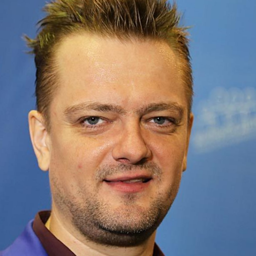

'img 0: pushnoj_01.png'

In [ ]:
EXT = ["png", "jpg", "jpeg"]
def display_folder_content(folder='aligned_images/', res = 256):
    for i, img_path in enumerate(sorted(os.listdir(folder))):
        if img_path.split('.')[-1] in EXT:
            path = os.path.join(folder,img_path)
            display(Image.open(path).resize((res,res)), "img {}: {}".format(i, img_path))
            print('\n')

display_folder_content('aligned_images')

In [ ]:
dlatent_path = "latents/"
latent_predictor_path = "image_to_latent.pt"
image_path = "aligned_images/" + os.listdir("aligned_images/")[0]

In [ ]:
from interfacegan.models.stylegan_generator import StyleGANGenerator

# Convert StyleGAN model from tensorflow to pytorch
converted_model = StyleGANGenerator("stylegan_ffhq")
# Get average vectors
avg_latents = converted_model.model.truncation.w_avg.view((-1, 1, 512))

# Get generator and latent optimization pipeline
synthesizer = converted_model.model.synthesis
latent_optimizer = LatentOptimizer(synthesizer, layer=9)

In [ ]:
# Load target image and get features
reference_image = transforms.ToTensor()(Image.open(image_path)).unsqueeze(0).to(device)
with torch.no_grad():
    reference_image = latent_optimizer.preprocess(reference_image)
    reference_features = latent_optimizer.feature_extractor(reference_image)

In [ ]:
# Predict initial approximation or get a random one
if latent_predictor_path:
    image_to_latent = InitialLatentPredictor().to(device)
    image_to_latent.load_state_dict(torch.load(latent_predictor_path))
    image_to_latent.eval()

    with torch.no_grad():
        initial_latents = image_to_latent(reference_image)
    initial_latents = initial_latents.detach().to(device).requires_grad_(True)
else:
    initial_latents = torch.zeros((1,18,512)).to(device).requires_grad_(True)

In [ ]:
from tqdm import tqdm

# Loss and optimizer
criterion = LatentLoss()
optimizer = torch.optim.Adam([initial_latents], lr=0.025)

# Iteratevly update latent vector using backprop
images = []
n_iters = 1000
progress_bar = tqdm(range(n_iters))
for step in progress_bar:
    optimizer.zero_grad()

    generated_image_features, generated_image = latent_optimizer(initial_latents)
    
    if step % 50 == 0:
        images.append(generated_image.detach().cpu())

    generated_image = latent_optimizer.preprocess(generated_image)
    loss = criterion(
        reference_features, generated_image_features,
        reference_image, generated_image,
        #avg_latents, initial_latents
    )
    loss.backward()
    optimizer.step()
    progress_bar.set_description("Loss = {}".format(loss.item()))

# Save optimized latent vector
optimized_dlatents = initial_latents.detach().cpu().numpy()
np.save(dlatent_path+"dlatents.npy", optimized_dlatents)

Loss = 0.4318670332431793: 100%|██████████| 1000/1000 [03:38<00:00,  4.59it/s]


In [ ]:
from skimage.transform import resize

def tensor_to_snapshot(x):
    x = x.squeeze().numpy()
    x = np.transpose(x, (1,2,0))
    x = resize(x, (256, 256))
    return x

images = [tensor_to_snapshot(x) for x in images]

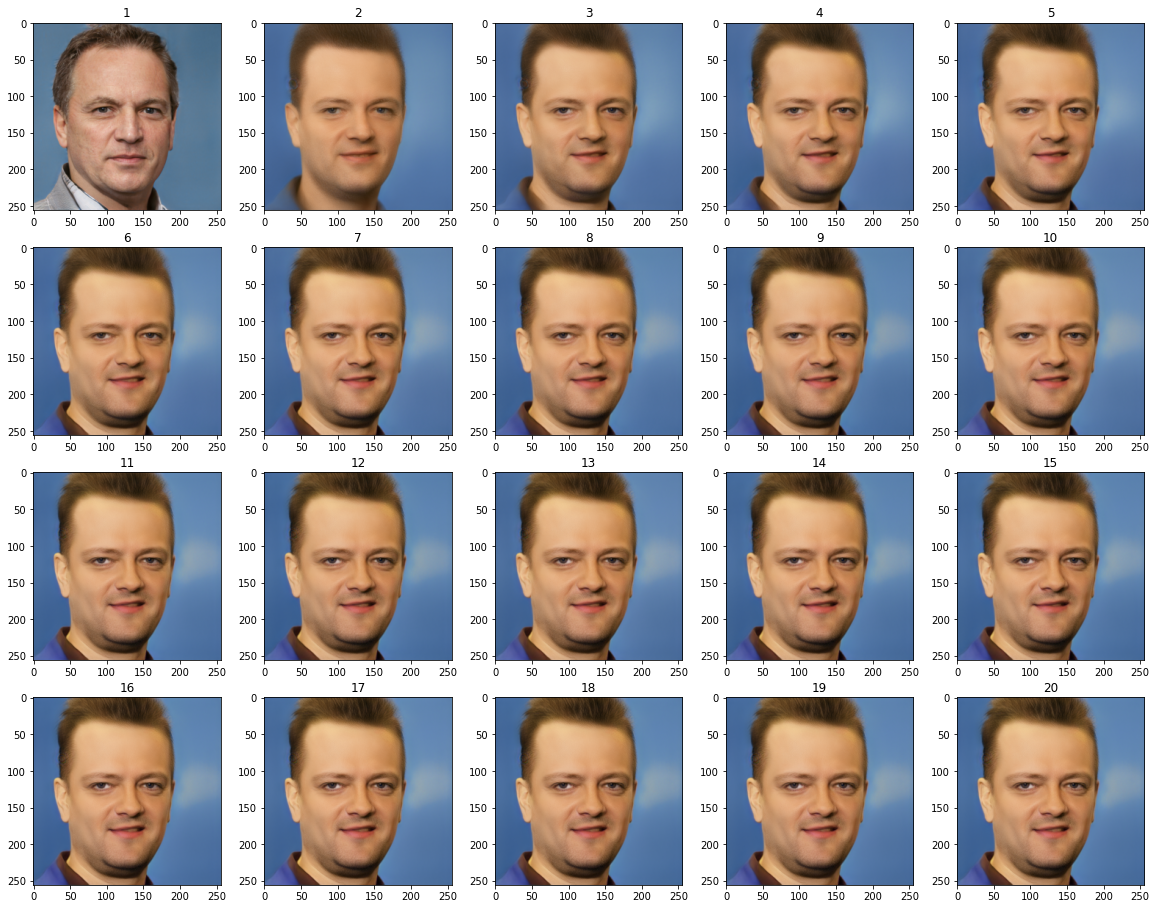

In [ ]:
figure = plt.figure(figsize=(20,20))
axis = []
for i in range(len(images)):
    axis.append(figure.add_subplot(5, 5, i + 1))
    axis[-1].set_title("{}".format(i+1))
    plt.imshow(images[i])
plt.show()

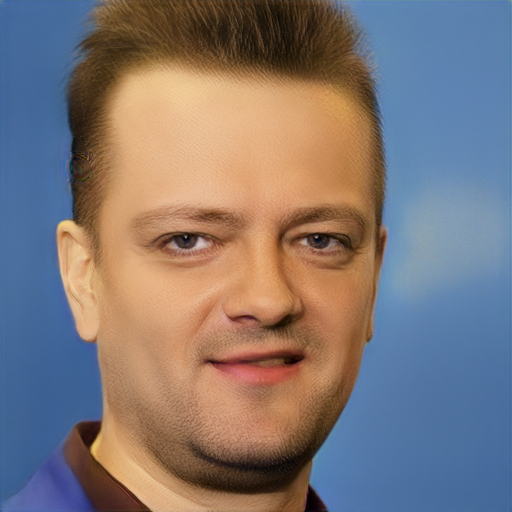

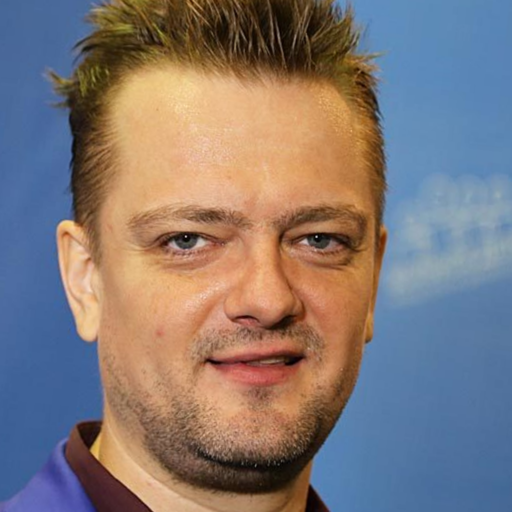

In [ ]:
post_process = lambda image: (255*denormalize(image)).detach().cpu().numpy().astype(np.uint8)[0]

# Generate images from predicted vectors and convert to Numpy 
pred_image = post_process(synthesizer(initial_latents))
pred_image = np.transpose(pred_image, (1,2,0))

display(Image.fromarray(pred_image).resize((512,512)), Image.open("aligned_images/pushnoj_01.png").resize((512,512)))